In [105]:
import numpy as np
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from bs4 import BeautifulSoup   

In [106]:
pd1 = pd.read_csv('./comments.csv')

In [107]:
pd1.head()

,body,subreddit
0,Do you think i’d be able to handle the really ...,oculus
1,"I own both games, but haven't tried VR in them...",oculus
2,"SDE still exists, but its waaaaaaaay less than...",oculus
3,Bought my rift used. Never spent a dime on the...,oculus
4,Nothing in real life bothers me. But there wer...,oculus


In [108]:
pd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16216 entries, 0 to 16215
Data columns (total 2 columns):
body         16216 non-null object
subreddit    16216 non-null object
dtypes: object(2)
memory usage: 253.5+ KB


In [109]:
pd1.dtypes

body         object
subreddit    object
dtype: object

In [110]:
pd1.shape

(16216, 2)

#### Label Target Variable

In [111]:
pd1['subreddit'].unique()

array(['oculus', 'Vive'], dtype=object)

In [112]:
# Target is 'subreddit'. 0 = Oculus, 1 = Vive

pd1.rename(columns={'subreddit':'target'}, inplace=True)

pd1 = pd1.replace('oculus', 0)
pd1 = pd1.replace('Vive', 1)

In [113]:
#Rename 'body' to 'comment'.
pd1.rename(columns={'body':'comment'}, inplace=True)

In [114]:
pd1.head()

,comment,target
0,Do you think i’d be able to handle the really ...,0
1,"I own both games, but haven't tried VR in them...",0
2,"SDE still exists, but its waaaaaaaay less than...",0
3,Bought my rift used. Never spent a dime on the...,0
4,Nothing in real life bothers me. But there wer...,0


#### Check for null fields

In [115]:
#there are no null fields.
pd1.isnull().sum()

comment    0
target     0
dtype: int64

In [116]:
#How about comment column with no strings? There are no comments with no words (ie. no strings).
#I do this check because if there are comments that have no words, these comments should be dropped
#as it does not add value to the analysis.
pd1[pd1['comment']=='']

,comment,target


#### Check for duplicate comments 

In [117]:
#I found out that there are 223 duplicated comments.
pd1.duplicated().sum()

212

In [118]:
#Examine some of the duplicated posts (Oculus)
pd1[pd1.duplicated()].head(20)

,comment,target
123,"Hello, we would like to learn more about the ...",0
144,"Hello, we would like to learn more about the ...",0
217,[deleted],0
347,"Btw, more here:\r\n\r\n""HTC Vive has two scree...",0
417,"This is plain dumb, sorry. Regardless of how m...",0
480,But the placement and quality of them are lack...,0
755,Yes,0
1025,Also absurd is his botched description of Ligh...,0
1106,Thanks,0
1197,Yes,0


In [119]:
#Examine some of the duplicated posts (Vive)
pd1[pd1.duplicated()].tail(20)

,comment,target
14986,Thanks!,1
15013,[deleted],1
15017,[deleted],1
15018,[deleted],1
15026,"If real, it’s likely that an announcement woul...",1
15067,[deleted],1
15075,[deleted],1
15220,[removed],1
15264,[removed],1
15301,"\r\nThanks for posting\r\n\r\nUnfortunately, y...",1


In [120]:
#At this point, I noticed that apart from potentially empty strings, 
#there are also deleted comments in the form of '[deleted]' and '[removed]'.
#I seek to remove the deleted comments and removed comments first.

pd1.drop(pd1[pd1['comment']=='[deleted]'].index, axis=0, inplace = True)
pd1.drop(pd1[pd1['comment']=='[removed]'].index, axis=0, inplace = True)

In [121]:
pd1.shape

(16168, 2)

In [122]:
#Drop all my duplicates

pd1.drop_duplicates(inplace=True)

In [123]:
pd1.shape

(16000, 2)

In [124]:
#Need to reset the indexes after removing duplicates
pd1= pd1.reset_index(drop=True)

In [125]:
pd1.index

RangeIndex(start=0, stop=16000, step=1)

#### Cleaning

In [126]:
def clean_text(comment):

    # 1. Remove HTML.
    comment_text = BeautifulSoup(comment).get_text()
    
    # 2. Remove non-letters (e.g.punctuations, emojis etc.).
    letters_only = re.sub("[^a-zA-Z]", " ", comment_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [127]:
#apply clean_text function to pd1.
pd1['comment'] = pd1['comment'].apply(clean_text)
    

C:\Users\User\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\User\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
C:\Users\User\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://en.wikipedia.org/wiki/The_Allegory_of_Love_(Veronese)" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C

C:\Users\User\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://youtu.be/5kq8oZ7s9M4

F" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\User\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://imgur.com/a/uKfY5" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\User\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://www.engadget.com/2019/09/25/oculus-link-quest-rift-VR/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

In [128]:
# drop rows where comment = ''
pd1 = pd1[pd1['comment'] != '']

In [129]:
#Need to reset the indexes after removing blank comments
pd1= pd1.reset_index(drop=True)

In [130]:
pd1.shape

(15906, 2)

#### Lemmatizing

In [131]:
# Instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()

In [132]:
# Define function to lemmatize the words.
def lemmatize_words(text):
    word = text.split()
    lemma_words = ''
    for i in word:
        lemma_words += lemmatizer.lemmatize(i) + ' '
    return lemma_words

In [133]:
#Apply lemmatize_words function to the comment column in pd1.
pd1['comment'] = pd1['comment'].apply(lemmatize_words)

In [134]:
pd1.head()

,comment,target
0,think able handle really well known vr game be...,0
1,game tried vr point fix,0
2,sde still exists waaaaaaaay le pentile screen ...,0
3,bought rift used never spent dime game market ...,0
4,nothing real life bother thing made vr time st...,0


In [135]:
pd1.shape

(15906, 2)

In [136]:
pd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15906 entries, 0 to 15905
Data columns (total 2 columns):
comment    15906 non-null object
target     15906 non-null int64
dtypes: int64(1), object(1)
memory usage: 248.6+ KB


In [137]:
pd1.isnull().sum()

comment    0
target     0
dtype: int64

In [138]:
#save as csv for modelling.
pd1.to_csv("clean_comments.csv", index=False)

#### Count Vectorizer

In [139]:
# Instantiate the "CountVectorizer" object for Oculus. 
# I limit the max features to 50 because I want to find the most frequently commented words.
# Used unigram and bigram because sometimes words such as 'happy' may be preceeded by 'not happy'.
# The former has a positive connotation while the latter has a negative connotation. 
# Hence it is important to also include bigram.
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 50,
                            ngram_range=(1,2)) 

In [140]:
vector_oculus = pd1[pd1['target'] == 0]['comment']

In [141]:
features_oculus = vectorizer.fit_transform(vector_oculus)

In [142]:
features_oculus = features_oculus.toarray()

In [143]:
print(features_oculus.shape)

(9823, 50)


In [144]:
vocab_oculus = vectorizer.get_feature_names()
print(vocab_oculus)

['also', 'better', 'cable', 'com', 'could', 'cv', 'even', 'first', 'game', 'get', 'go', 'going', 'good', 'got', 'headset', 'http', 'issue', 'know', 'like', 'link', 'look', 'lot', 'make', 'much', 'need', 'oculus', 'one', 'pc', 'people', 'play', 'quest', 'really', 'rift', 'right', 'see', 'still', 'support', 'sure', 'thing', 'think', 'though', 'time', 'use', 'vr', 'want', 'way', 'well', 'work', 'would', 'year']


In [145]:
# Create a word cloud based on the top 50 frequently commented words.
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [146]:
oculus_content = str([i for i in vocab_oculus])

In [147]:
oculus_content = oculus_content.replace("'", "")

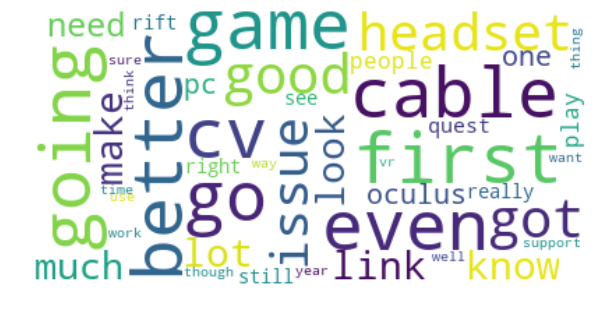

In [148]:
wordcloud_oculus = WordCloud(max_font_size=50, max_words=50, background_color="white",
                     contour_width=2, contour_color='firebrick').generate(oculus_content)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud_oculus, interpolation="bilinear")
plt.axis("off")
plt.show()

In [149]:
# Instantiate the "CountVectorizer" object for Vive. 
# I limit the max features to 50 because I want to find the most frequently commented words.
# Used unigram and bigram because sometimes words such as 'happy' may be preceeded by 'not happy'.
# The former has a positive connotation while the latter has a negative connotation. 
# Hence it is important to also include bigram.

vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 50, 
                             ngram_range=(1,2)) 

In [150]:
vector_vive = pd1[pd1['target'] == 1]['comment']

In [151]:
features_vive = vectorizer.fit_transform(vector_vive)

In [152]:
features_vive = features_vive.toarray()

In [153]:
print(features_vive.shape)

(6083, 50)


In [154]:
vocab_vive = vectorizer.get_feature_names()
print(vocab_vive)

['also', 'better', 'buy', 'com', 'controller', 'could', 'even', 'game', 'get', 'go', 'good', 'headset', 'http', 'http www', 'index', 'issue', 'know', 'like', 'look', 'make', 'much', 'need', 'new', 'oculus', 'one', 'people', 'play', 'pro', 'quest', 'really', 'rift', 'right', 'see', 'still', 'thing', 'think', 'though', 'time', 'tracking', 'use', 'valve', 'vive', 'vr', 'want', 'way', 'well', 'wireless', 'work', 'would', 'www']


In [155]:
vive_content = str([i for i in vocab_vive])

In [157]:
vive_content = vive_content.replace("'", "")

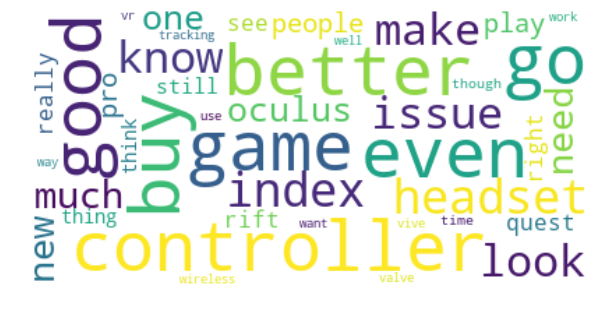

In [158]:
wordcloud_vive = WordCloud(max_font_size=50, max_words=50, background_color="white",
                     contour_width=2, contour_color='firebrick').generate(vive_content)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud_vive, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Sentiment Analysis

In [159]:
from nltk.stem.porter import PorterStemmer

In [160]:
# Source of positive and negative words for sentiment analysis taken from below url:
#https://github.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/tree/master/data/opinion-lexicon-English

pd_pos = pd.read_csv('./positive_words.csv')

In [161]:
pd_pos.head()

,positive
0,abound
1,abounds
2,abundance
3,abundant
4,accessable


In [162]:
pd_neg = pd.read_csv('./negative_words.csv')

In [163]:
pd_neg.head()

,negative
0,abnormal
1,abolish
2,abominable
3,abominably
4,abominate


In [164]:
positive_words = list(pd_pos['positive'])

In [165]:
negative_words = list(pd_neg['negative'])

In [166]:
def sentiment_analyser(text):
#Lemmatize our words
    word = text.split()
    word_len = len(word)
    lemma_words = [lemmatizer.lemmatize(i) for i in word]
    
    # Lemmatize our positive words.
    lemma_pos = [lemmatizer.lemmatize(pos_word) for pos_word in positive_words]
    pos_set = set(lemma_pos)    
                         
    # Lemmatize our negative words.
    lemma_neg = [lemmatizer.lemmatize(neg_word) for neg_word in negative_words]
    neg_set = set(lemma_neg)
                         
    # Count "positive" words.
    # add 1 to the count each time a positive word is found in the list of lemmatized words
    pos_count = 0
    neg_count = 0           
    for i in lemma_words:
        if i in pos_set:
            pos_count += 1
        elif i in neg_set:
            neg_count += 1 
    # Calculate Sentiment Percentage 
    # (Positive Count - Negative Count) / (Total Count)
    res = (pos_count - neg_count)/word_len
    #print(pos_count,neg_count,word_len)
    return round(res,4)


In [120]:
#analyse sentiments for each comment
pd1['comment'].apply(sentiment_analyser)

0        0.0625
1        0.0000
2        0.0000
3       -0.0769
4       -0.1250
5        0.0000
6       -0.3000
7        0.0000
8        0.0000
9        0.3333
10       0.0000
11       0.1250
12       0.0000
13       0.0000
14      -0.1250
15       0.1000
16       0.0000
17       0.0000
18       0.0000
19      -0.0690
20       0.0400
21       0.1176
22       0.0000
23       0.0000
24      -0.0909
25       0.0000
26       0.0000
27       0.0000
28       0.0000
29       0.0000
          ...  
15876    0.1026
15877    0.0000
15878   -0.0769
15879   -0.5000
15880    0.2500
15881    0.0000
15882    0.0909
15883    0.2500
15884    0.0217
15885    0.1765
15886    0.0000
15887    0.0833
15888    0.0000
15889    0.0000
15890    0.3333
15891   -0.1250
15892   -0.1250
15893   -0.2500
15894    0.0000
15895    0.0000
15896   -0.1667
15897    0.2857
15898    0.1667
15899   -0.0800
15900   -0.0345
15901    0.0000
15902    0.1000
15903    0.0571
15904    0.1667
15905    0.1000
Name: comment, Length: 1

In [121]:
#The Sentiment Analysis of the mean of Oculus's comments is slightly positive.
pd1[pd1['target'] == 0]['comment'].apply(sentiment_analyser).mean()

0.028486541789677265

In [122]:
#The Sentiment Analysis of the mean of Vive's comments is more positive than Oculus.
pd1[pd1['target'] == 1]['comment'].apply(sentiment_analyser).mean()

0.0437396021699817

From the Sentiment Analysis, I conclude that the comments are generally more positive for Vive than for Oculus (0.0437 vs 0.0285). This would mean that netizens are more receptive towards using Vive and thus Vive has a greater popularity than Oculus. 

However, there are certain limitations to the Sentiment Analysis I employed.

1. Although I used an extensive list of words from an online source, the list of positive and negative words are not exhaustive. Hence the sentiment analysis can only provide a rough gauge of consumer's sentiments for each subreddit but to compare them against each other would require greater research, especially on technical jargons. 


2. The list of words I chose for positive and negative words may be chosen out of context. For example, the word 'worry' is a negative word. However, the user may have typed 'no need to worry' in his comment which may then be viewed positively. Hence, more investigation is required to understand what is the context to each comment posted by users. In the online source I used, it only included unigrams and bigrams. N-gram could be explored in future for a more accurate sentiment analysis.
